# Data Generation for pty-co-SAXSNN (supervised CNN)

## Import necessary packages

In [1]:
import cupy as cp
from cupyx.scipy.fft import fft2, fftshift, ifft2, ifftshift
from cupyx.scipy.signal import convolve2d as conv2
from cupyx.scipy.ndimage import zoom as zoom_gpu

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import tifffile
import sys
import random
import os
from pathlib import Path

from tqdm import tqdm

import h5py

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/')))

from utils.ptychosaxsNN_utils import load_and_prepare_data, rotate_lattice_gpu, \
                                    hanning_gpu,add_poisson_noise_to_dp, calculate_rotation_angles

# import utils.ptychosaxsNN as ptNN
# import importlib
# importlib.reload(ptNN)

from ptycho_tomo.ptycho_tomo_funcs import resize_probe_fourier

basedir=Path('/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/')

## Define color map

In [2]:
# Create custom colormap for #3dde5f
colors_3dde5f = [(0, 0, 0), (0.239, 0.871, 0.373)]  # Black to #3dde5f
n_bins = 100  # Number of color gradations
cmap_3dde5f = LinearSegmentedColormap.from_list('custom_green', colors_3dde5f, N=n_bins)

## Load and plot pinhole that will be used during simulation for smoothening

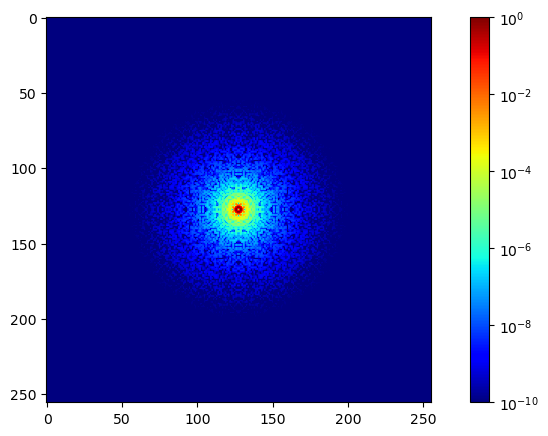

In [4]:
# pinhole simulation located in src/utils/pinhole_sim.py
psf_pinhole = np.load(basedir / 'data/probes/probe_pinhole.npy')
plt.figure(figsize=(10,5))
im1=plt.imshow(np.abs(psf_pinhole)**2,cmap='jet',norm=colors.LogNorm(),clim=(1e-10,1))
plt.colorbar(im1)
plt.show()        

## Load lattice and probe (and mask for visualization)

In [5]:
# Sample info for probe from ptycho experiment at 12IDE (PtychoShelves)
sample_dir = 'ZCB_9_3D_'
base_directory = '/net/micdata/data2/12IDC/2025_Feb/results/'
recon_path = 'roi0_Ndp256/MLc_L1_p10_gInf_Ndp128_mom0.5_pc0_maxPosError500nm_bg0.1_vi_mm/MLc_L1_p10_g100_Ndp256_mom0.5_pc800_maxPosError500nm_bg0.1_vp4_vi_mm/'
Niter = 1000
scan_number = 5065
# the above probe is saved in ../data/probes/probe_ZCB_9_3D_5065.mat

# Lattice path
lattice_path = '../data/lattices/clathrate_II_simulated_400x400x400_48x48x48unitcells.tif'

# Load mask
mask = np.load('../data/masks/mask_ZCB_9_3D.npy')

## Set simulation parameters

For the manuscript, 9600 patterns are simulated for training, testing and validation.

In [6]:
# GPU device selection
gpu_id = 0  # Change this to select different GPU (0, 1, 2, etc.)
cp.cuda.Device(gpu_id).use()

# Intialize parameters
lattice_size = 400 # Implicitly controls padding of the lattice
dpsize = 256 # Final output size
sim_size = 256 #1024  # Size for simulation (can be larger than dpsize)
grid_size = sim_size * 4  # Pad the lattice for scanning
nsteps = 4
nscans = 180 #600
zoom_lattice = False
zoom_factor = 1.0
center_concentration = 0.75 # Controls degree of illumination between the lattice and the probe
plot = False
total_plot = False
plot_overlay = False
chosen_frame_index = [0, 10] # ROI index to plot if plot_overlay is True
total = False
noise_on = True
Nc_avg = 1e4  # Average counts per pixel (adjust as needed)
tomo_sim = True
hkl_sim = False# Only works for cubic lattices
hr, kr, lr = 1, 1, 1 #1,0,0  ;   1,1,0  ;  1,1,1 ;  3,1,1   
random_initial_rotation = False

# Absorption/phase controls
absorption_on = False
absorption_coeff = 5.0  # increases absorption strength; 0 => no absorption
phase_scale = 1.0       # scales phase shift from amplitude_2d

# HDF5 saving options
save_h5 = True

# Create a useful 'dr' string for a saved filename
dr = f"Lattice{lattice_size}"

# Add lattice type string (robust to path structure)
lattice_type_split = lattice_path.split('/')[-1].split('_')
if len(lattice_type_split) >= 5:
    lattice_type = lattice_type_split[-5] + '_' + lattice_type_split[-4]
else:
    lattice_type = "Unknown"
dr += f"_Type{lattice_type}"

dr += f"_DP{dpsize}"
dr += f"_Sim{sim_size}"
dr += f"_Grid{grid_size}"
dr += f"_nsteps{nsteps}"
dr += f"_nscans{nscans}"
if zoom_lattice:
    dr += f"_zoom{zoom_factor:.2f}"
dr += f"_centerConc{center_concentration:.2f}"
dr += f"_Noise{'On' if noise_on else 'Off'}"
dr += f"_Nc{int(Nc_avg)}"
if hkl_sim:
    dr += f"_hkl{hr}{kr}{lr}"
if tomo_sim:
    dr += f"_tomo"
if absorption_on:
    dr += f"_Abs{absorption_coeff}"
else:
    dr += f"_Abs0"
dr += f"_PhaseScl{phase_scale:.2f}"
dr += f"_{sample_dir.strip('_')}"
dr += f"_scan{scan_number}"


print('Output directory: ', dr)

#h5_out_dir = f'/net/micdata/data2/12IDC/ptychosaxs/batch_mode/hkl/{dr}'
h5_out_dir = f'../example/01_Data_Generation/{dr}'
# h5_out_dir = f'/net/micdata/data2/12IDC/ptychosaxs/data/diff_sim/{dr}'
if save_h5:
    os.makedirs(h5_out_dir, exist_ok=True)

Output directory:  Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans180_centerConc0.75_NoiseOn_Nc10000_tomo_Abs0_PhaseScl1.00_ZCB_9_3D_scan5065


## Simulation cell

In [7]:
# Load lattice and move to GPU
amplitude_3d = cp.array(tifffile.imread(lattice_path))

# Load and prepare data
ob_w, pb1 = load_and_prepare_data(base_directory,sample_dir,recon_path,scan_number,Niter)

#Resize probe
if pb1.shape[0] != dpsize:
    pb1=resize_probe_fourier(pb1, dpsize,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    pb1=cp.array(pb1)
else:
    pb1=cp.array(pb1)


if plot:
    plt.imshow(np.abs(cp.asnumpy(pb1)))
    plt.show()

# Load pinhole and PSF
#pbp = np.load('/home/beams/PTYCHOSAXS/NN/probe_pinhole_complex_256x256_bw0.75.npy')
psf_pinhole = np.abs(np.load('../data/probes/probe_pinhole.npy'))
psf_pinhole=cp.array(psf_pinhole)


original_lattice_size = lattice_size
original_amplitude_3d = amplitude_3d.shape[0]
if zoom_lattice:
    amplitude_3d = zoom_gpu(amplitude_3d, (zoom_factor, zoom_factor, zoom_factor), order=1)
    lattice_size = int(original_lattice_size * zoom_factor)
else:
    amplitude_3d = amplitude_3d
# Initialize count
count = 1

# Prepare single overlay figure for all chosen ROIs
if plot_overlay:
    fig_overlay, ax_overlay = plt.subplots(figsize=(8,8))
    base_image_drawn = False
    probe_plotted = False

# Define scan pattern - center in the middle of the grid
center_x = grid_size // 2
center_y = grid_size // 2
scan_range = int(lattice_size * center_concentration)
start_x = center_x - scan_range // 2
start_y = center_y - scan_range // 2
step_size_x = scan_range // (nsteps-1) if nsteps > 1 else 0
step_size_y = scan_range // (nsteps-1) if nsteps > 1 else 0

# Preallocate single HDF5 file for entire simulation
total_frames = nscans * nsteps * nsteps
h5_file = os.path.join(h5_out_dir, f'sim_{sample_dir}S{scan_number:04d}_N{nscans}_steps{nsteps}_dp{dpsize}.h5')
if save_h5:
    h5f = h5py.File(h5_file, 'w')
    # datasets for diffraction patterns
    dset_conv = h5f.create_dataset(
        'convDP', shape=(total_frames, dpsize, dpsize), dtype='float32',
        chunks=(1, dpsize, dpsize), compression='gzip', compression_opts=4
    )
    dset_ideal = h5f.create_dataset(
        'idealDP', shape=(total_frames, dpsize, dpsize), dtype='float32',
        chunks=(1, dpsize, dpsize), compression='gzip', compression_opts=4
    )
    # metadata
    h5f.attrs['nscans'] = int(nscans)
    h5f.attrs['nsteps'] = int(nsteps)
    h5f.attrs['dpsize'] = int(dpsize)
    h5f.attrs['sim_size'] = int(sim_size)
    h5f.attrs['grid_size'] = int(grid_size)
    h5f.attrs['lattice_size'] = int(lattice_size)
    h5f.attrs['sample_dir'] = sample_dir
    h5f.attrs['base_directory'] = base_directory
    h5f.attrs['recon_path'] = recon_path
    h5f.attrs['Niter'] = int(Niter)
    h5f.attrs['scan_number'] = int(scan_number)
    # store probe once
    try:
        h5f.create_dataset('probe', data=cp.asnumpy(pb1).astype(np.complex64))
    except TypeError:
        # fallback: store real/imag separately if complex dtype unsupported
        h5f.create_dataset('probe_real', data=cp.asnumpy(cp.real(pb1)).astype(np.float32))
        h5f.create_dataset('probe_imag', data=cp.asnumpy(cp.imag(pb1)).astype(np.float32))
    # rotation angles per scan and positions per frame
    dset_rotation = h5f.create_dataset('rotation_angles', shape=(nscans, 3), dtype='float32')
    dset_indices = h5f.create_dataset('indices_ik', shape=(total_frames, 2), dtype='int32')
    dset_probe_center = h5f.create_dataset('probe_center_xy', shape=(total_frames, 2), dtype='int32')

# Random initial rotation angles
if random_initial_rotation:
    rotation_angles = [random.randint(0,90), random.randint(0,90), random.randint(0,90)]
    amplitude_3d = rotate_lattice_gpu(amplitude_3d, rotation_angles)


# Main simulation loop
for l in tqdm(range(nscans)):
    # Initialize arrays
    total_intensity = cp.zeros((dpsize, dpsize))
    total_intensity_conv = cp.zeros((dpsize, dpsize))
    # Random rotation angles
    if tomo_sim:
        rotation_angles = [0,1.0*l,0]
    elif hkl_sim:
        # Define the Miller indices for the desired reflection
        rotation_angles = calculate_rotation_angles(hr, kr, lr)
    else:
        rotation_angles = [random.randint(0,90), random.randint(0,90), random.randint(0,90)]
    
    
    # Rotate lattice on GPU using the new function
    amplitude_3d_rotated = rotate_lattice_gpu(amplitude_3d, rotation_angles)
    if save_h5:
        dset_rotation[l, :] = np.array(rotation_angles, dtype=np.float32)
    if plot:
        plt.imshow(np.abs(cp.asnumpy(fftshift(fft2(cp.sum(amplitude_3d_rotated[:,:,:],axis=2))))),norm=colors.LogNorm(),cmap='jet')
        plt.colorbar()
        plt.show()
    if plot_overlay:
        counter=1
    for k in range(nsteps):
        for i in range(nsteps):
            frame_index = l * (nsteps * nsteps) + k * nsteps + i
            # Project and process on GPU
            amplitude_2d = cp.sum(amplitude_3d_rotated, axis=2)
            # Normalize to [0,1] with small epsilon for numerical stability
            amplitude_2d = (amplitude_2d - cp.min(amplitude_2d)) / (cp.max(amplitude_2d) - cp.min(amplitude_2d)+1e-12)
            
            # Create complex transmission with absorption and phase
            if absorption_on:
                transmission_amp = cp.exp(-absorption_coeff * amplitude_2d)
                particles_2d = transmission_amp * cp.exp(1j * phase_scale * amplitude_2d)
            else:
                transmission_amp = cp.ones_like(amplitude_2d)
                particles_2d = cp.exp(1j * amplitude_2d)
            particles_2d = hanning_gpu(particles_2d) * particles_2d

            # Pad on GPU
            padding = (grid_size - lattice_size) // 2
            bkg = 0.0+0j
            pad_value = 0.0 + 0j  # vacuum transmission outside object
            particles_padded = cp.pad(particles_2d+bkg, pad_width=padding, mode='constant', constant_values=pad_value)
            particles_padded=particles_padded*hanning_gpu(particles_padded)

            # Calculate probe position
            probe_center_x = start_x + i * step_size_x
            probe_center_y = start_y + k * step_size_y
            p_hw = int(pb1.shape[0]/2)

            # Extract illuminated region
            ob_w_2 = particles_padded
            ob_e_2 = ob_w_2[probe_center_x-p_hw:probe_center_x+p_hw, 
                            probe_center_y-p_hw:probe_center_y+p_hw] * \
                        hanning_gpu(ob_w_2[probe_center_x-p_hw:probe_center_x+p_hw,
                                        probe_center_y-p_hw:probe_center_y+p_hw])
            
            
            # Calculate diffraction patterns
            psi_k_2_ideal = fftshift(fft2(ob_e_2))# * pbp)
    
            # Calculate exit wave for conventional ptychography
            psi_k_2 = fftshift(fft2(pb1 * ob_e_2))

            # Calculate pinhole diffraction pattern with conv (low pass filter, smoothening pinhole pattern)
            psi_k_2_ideal = conv2(cp.abs(psi_k_2_ideal), cp.abs(psf_pinhole), 'same', boundary='symm')
            
            if noise_on:
                dp_true, dp, snr = add_poisson_noise_to_dp(psi_k_2, Nc_avg=Nc_avg, N=sim_size, use_gpu=True)
                dp_true_ideal, dp_ideal, snr_ideal = add_poisson_noise_to_dp(psi_k_2_ideal, Nc_avg=Nc_avg, N=sim_size, use_gpu=True)
                
                # Calculate intensities
                conv_DP = dp  # This now includes Poisson noise
                ideal_DP = dp_ideal
                
                ideal_DP = cp.abs(psi_k_2_ideal)**2
            else:
                conv_DP=cp.abs(psi_k_2)**2
                ideal_DP=cp.abs(psi_k_2_ideal)**2

            # Accumulate probe outlines over a single padded object figure
            if plot_overlay:
                if not base_image_drawn:
                    im_bg = ax_overlay.imshow(
                        (np.angle(cp.asnumpy(ob_w_2)) * np.abs(cp.asnumpy(ob_w_2)))[128:-128,128:-128],
                        cmap=cmap_3dde5f
                    )
                    # Make axes tick marks larger
                    ax_overlay.tick_params(axis='both', which='major', labelsize=16)
                    ax_overlay.tick_params(axis='both', which='minor', labelsize=12)
                    #ax_overlay.set_title('Probe Positions on Padded Object (Combined)')
                    base_image_drawn = True

                if frame_index in chosen_frame_index:
                    rect = plt.Rectangle(
                        (probe_center_y-p_hw, probe_center_x-p_hw),
                        pb1.shape[1], pb1.shape[0],
                        fill=False, color='#fcd83f', linewidth=3, linestyle='--'
                    )
                    ax_overlay.add_patch(rect)
                    ax_overlay.text(
                        probe_center_y-p_hw, probe_center_x-p_hw-5,
                        #f'ROI {counter} (frame {frame_index})', color='#fcd83f', fontsize=14
                        f'ROI {counter}', color='#fcd83f', fontsize=14
                    )
                    # Also plot diffraction patterns for this ROI
                    fig_roi, ax_roi = plt.subplots(1, 3, figsize=(14, 4))
                    mask=np.load('../data/masks/mask_ZCB_9_3D.npy')
                    im0 = ax_roi[0].imshow(np.abs(cp.asnumpy(conv_DP)*mask+1e-4), norm=colors.LogNorm(), cmap='jet')
                    ax_roi[0].set_title(f'Conv DP (ROI {counter}, frame {frame_index})')
                    im1 = ax_roi[1].imshow(np.abs(cp.asnumpy(ideal_DP)+1), norm=colors.LogNorm(), cmap='jet')
                    ax_roi[1].set_title(f'Ideal DP (frame {frame_index})')
                    ax_roi[2].imshow(np.abs(cp.asnumpy(ob_e_2)), cmap='gray')
                    ax_roi[2].imshow(np.abs(cp.asnumpy(pb1)), cmap='gray', alpha=0.2)
                    ax_roi[2].set_title(f'ROI region + probe\n(frame {frame_index}, center=({probe_center_x},{probe_center_y}))')
                    plt.colorbar(im0, ax=ax_roi[0], fraction=0.046, pad=0.04)
                    plt.colorbar(im1, ax=ax_roi[1], fraction=0.046, pad=0.04)
                    plt.tight_layout()
                    
                    # Plot real space probe with yellow outline (only once)
                    if not probe_plotted:
                        fig_probe, ax_probe = plt.subplots(figsize=(8, 8))
                        im_probe = ax_probe.imshow(np.abs(cp.asnumpy(pb1)), cmap='Reds')
                        # Set axes spines zorder lower so rectangle appears above
                        for spine in ax_probe.spines.values():
                            spine.set_zorder(1)
                        rect_probe = plt.Rectangle(
                            (2, 2),
                            pb1.shape[1]-6, pb1.shape[0]-6,
                            fill=False, color='#fcd83f', linewidth=8, linestyle='--',
                            zorder=5
                        )
                        ax_probe.add_patch(rect_probe)
                        ax_probe.set_xticks([])
                        ax_probe.set_yticks([])
                        ax_probe.set_xlabel('')
                        ax_probe.set_ylabel('')
                        ax_probe.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
                        probe_plotted = True
                    
                    counter+=1
            
            # Bin diffraction patterns back to dpsize if simulation size is different
            if sim_size != dpsize:
                bin_factor = sim_size // dpsize
                conv_DP = bin_ndarray(conv_DP, (dpsize, dpsize), operation='sum')
                ideal_DP = bin_ndarray(ideal_DP, (dpsize, dpsize), operation='sum')

            # Resize and accumulate total intensities
            if total:
                total_intensity += cp.array(resize(cp.asnumpy(ideal_DP), (256,256), preserve_range=True, anti_aliasing=True))
                total_intensity_conv += cp.array(resize(cp.asnumpy(conv_DP), (256,256), preserve_range=True, anti_aliasing=True))

            # Apply mask and visualize
            if plot:
                fig,ax=plt.subplots(2,2)
                ax[0][0].imshow(np.abs(cp.asnumpy(ideal_DP)),norm=colors.LogNorm(),cmap='jet')
                ax[0][1].imshow(np.abs(cp.asnumpy(ideal_DP)),norm=colors.LogNorm(),cmap='jet')
                ax[1][0].imshow(np.abs(cp.asnumpy(conv_DP)*mask),norm=colors.LogNorm(),cmap='jet')
                ax[1][1].imshow(np.abs(cp.asnumpy(ob_e_2)),cmap='gray')
                ax[1][1].imshow(np.abs(cp.asnumpy(pb1)),cmap='gray',alpha=0.2)
                plt.show()
            # Write to HDF5 if enabled
            if save_h5:
                dset_conv[frame_index, :, :] = cp.asnumpy(conv_DP)
                dset_ideal[frame_index, :, :] = cp.asnumpy(ideal_DP)
                dset_indices[frame_index, :] = np.array([i, k], dtype=np.int32)
                dset_probe_center[frame_index, :] = np.array([int(probe_center_x), int(probe_center_y)], dtype=np.int32)
                
    # Plot results if enabled
    if total_plot:
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.imshow(cp.asnumpy(total_intensity), norm=colors.LogNorm(), cmap='jet')
        plt.colorbar()
        plt.subplot(122)
        plt.imshow(cp.asnumpy(total_intensity_conv), norm=colors.LogNorm(), cmap='jet')
        plt.colorbar()
        plt.show()
if save_h5:
    h5f.close()

# Show the combined overlay once after processing
if plot_overlay:
    plt.show()

100%|██████████| 180/180 [03:18<00:00,  1.10s/it]


## Print total number of diffraction patterns

In [ ]:
print(f'Generated {total_frames} frames of {dpsize}x{dpsize} diffraction patterns.')

Generated 960 frames of 256x256 diffraction patterns.


## Plot example pattern

Available datasets: ['convDP', 'idealDP', 'indices_ik', 'probe', 'probe_center_xy', 'rotation_angles']


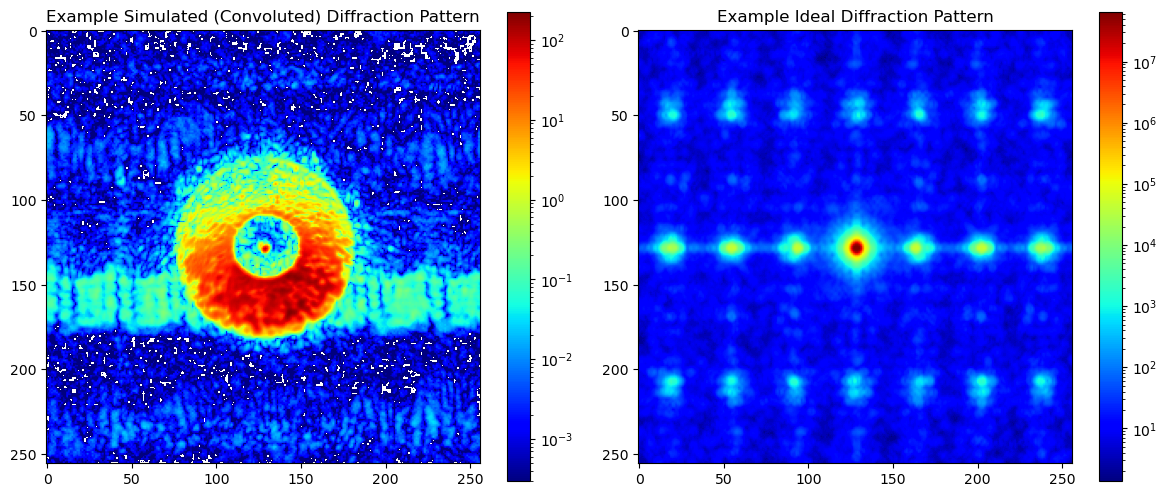

In [16]:
# Specify the HDF5 file path used in the earlier simulation
example_h5_path = h5_file
with h5py.File(example_h5_path, "r") as h5f:
    # Check available datasets
    print("Available datasets:", list(h5f.keys()))
    # Plot both 'convDP' (convoluted diffraction pattern) and 'idealDP' (ideal diffraction pattern) as examples
    dset_conv = h5f['convDP']
    dset_ideal = h5f['idealDP']

    ri=np.random.randint(0,total_frames)

    example_conv_dp = dset_conv[ri]
    example_ideal_dp = dset_ideal[ri]

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(example_conv_dp, norm=colors.LogNorm(), cmap='jet')
    plt.title('Example Simulated (Convoluted) Diffraction Pattern')
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(example_ideal_dp, norm=colors.LogNorm(), cmap='jet')
    plt.title('Example Ideal Diffraction Pattern')
    plt.colorbar()

    plt.tight_layout()
    plt.show()